In [1]:
import numpy as np
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from graphviz import Digraph

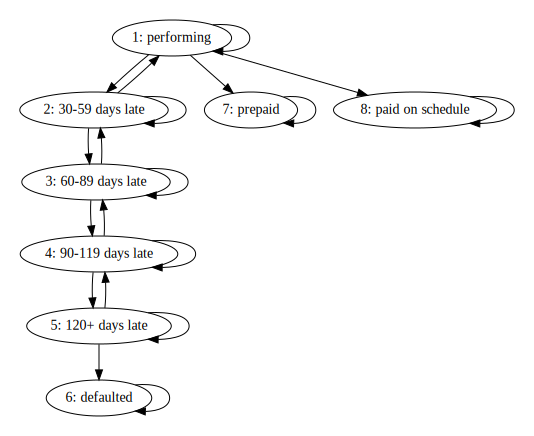

In [2]:
g = Digraph('loans')
with g.subgraph(name='cluster1') as b:
    b.attr(rank='same', color='white')
    b.node('1', '1: performing')
    b.node('2', '2: 30-59 days late')
    b.node('3', '3: 60-89 days late')
    b.node('4', '4: 90-119 days late')
    b.node('5', '5: 120+ days late')
    b.node('6', '6: defaulted')
    b.node('7', '7: prepaid')
    b.node('8', '8: paid on schedule')

g.edge('1','1')
g.edge('1','2')
g.edge('1','7')
g.edge('1','8')

g.edge('2','1')
g.edge('2','2')
g.edge('2','3')

g.edge('3','2')
g.edge('3','3')
g.edge('3','4')

g.edge('4','3')
g.edge('4','4')
g.edge('4','5')

g.edge('5','4')
g.edge('5','5')
g.edge('5','6')

g.edge('6','6')
g.edge('7','7')
g.edge('8','8')
g

In [3]:
# SMM = 1 – (1 – CPR)1/12

cpr = 0.12
smm = 1 - (1 - cpr) ** (1/12)
cpr, smm

(0.12, 0.010596241035318976)

In [4]:
cdr = 0.12
smm_d = 1 - (1 - cdr) ** (1/12)
cdr, smm_d

(0.12, 0.010596241035318976)

In [5]:
def makeA(term, cpn, matrix, length):
    Alist = []
    bal = 100
    pmt = bal * ((cpn/12) * (1+cpn/12) ** term) / ((1+cpn/12)**term-1)
    bal_prin = []
    pmt_i = []
    pmt_p = []
    pmt_t = []
    for i in range(0,term+1):
        if i == 0:
            pmt_i.append(0)
            pmt_p.append(0)
            pmt_t.append(0)
            bal_prin.append(bal)
        else:
            pmt_t.append(pmt)
            pmt_i.append(bal_prin[i-1] * cpn/12)
            pmt_p.append(pmt-pmt_i[i])
            bal_prin.append(bal_prin[i-1]-pmt_p[i])
    prinpct = [np.nan]
    for i in range(1,len(bal_prin)):
        prinpct.append(pmt_p[i]/bal_prin[i-1])
    if length > term:
        for i in range(length-term):
            prinpct.append(100)
    for i in range(len(prinpct)):
        mx = matrix.copy()
        mx[np.shape(mx)[0]-1,0] = min(prinpct[i], mx[0,0])
        mx[0,0] = mx[0,0] - min(prinpct[i], mx[0,0])
        Alist.append(mx)
    return Alist
    

In [6]:
A = np.array(  [[0.98, 0.25, 0, 0, 0, 0, 0, 0], 
                [0.01, 0.5, 0.2, 0, 0, 0, 0, 0], 
                [0, 0.25, 0.5, 0.15, 0, 0, 0, 0], 
                [0, 0, 0.3, 0.5, 0.1, 0, 0, 0], 
                [0, 0, 0, 0.35, 0.5, 0, 0, 0], 
                [0, 0, 0, 0, 0.4, 1, 0, 0], 
                [0.01, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 1]])
A, np.ones(8) @ A

(array([[0.9800, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0100, 0.5000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.5000, 0.1500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3000, 0.5000, 0.1000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3500, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 1.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]]),
 array([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]))

In [7]:
p0 = np.array([1,0,0,0,0,0,0,0])
pk = p0
print(f'    bal    30-59  60-89  90-119 120+   dflt   ppay   schd prn')
for k in range(100):
    if k == 0:
        pk = np.array(list(float(pk[x]) for x in range(len(pk))))
        p = pk
    else:
        pk = makeA(60, 0.05, A, 100)[k] @ pk
        p = np.vstack([p,pk])
    print(f'{k}: {pk}', sep='\n')

    bal    30-59  60-89  90-119 120+   dflt   ppay   schd prn
0: [1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
1: [0.9653 0.0100 0.0000 0.0000 0.0000 0.0000 0.0100 0.0147]
2: [0.9340 0.0147 0.0025 0.0000 0.0000 0.0000 0.0197 0.0292]
3: [0.9047 0.0172 0.0049 0.0008 0.0000 0.0000 0.0290 0.0434]
4: [0.8768 0.0186 0.0069 0.0018 0.0003 0.0000 0.0380 0.0575]
5: [0.8500 0.0194 0.0084 0.0030 0.0008 0.0001 0.0468 0.0715]
6: [0.8241 0.0199 0.0095 0.0041 0.0014 0.0004 0.0553 0.0853]
7: [0.7990 0.0201 0.0103 0.0050 0.0022 0.0010 0.0636 0.0989]
8: [0.7745 0.0201 0.0109 0.0058 0.0028 0.0019 0.0715 0.1124]
9: [0.7507 0.0200 0.0114 0.0065 0.0035 0.0030 0.0793 0.1258]
10: [0.7274 0.0198 0.0117 0.0070 0.0040 0.0044 0.0868 0.1390]
11: [0.7047 0.0195 0.0118 0.0074 0.0045 0.0060 0.0941 0.1521]
12: [0.6825 0.0192 0.0119 0.0077 0.0048 0.0078 0.1011 0.1651]
13: [0.6607 0.0188 0.0119 0.0079 0.0051 0.0097 0.1079 0.1780]
14: [0.6395 0.0184 0.0118 0.0080 0.0053 0.0117 0.1145 0.1907]
15: [0.6186 0.0179

<AxesSubplot:>

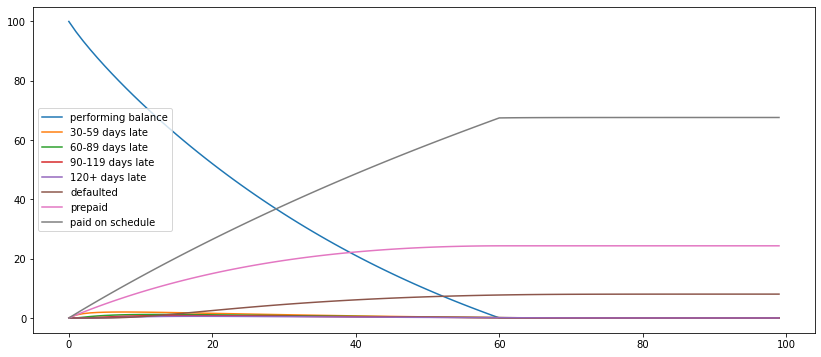

In [8]:
p100 = p * 100
data = {
    'performing balance' : p100[:,0],
    '30-59 days late' : p100[:,1],
    '60-89 days late' : p100[:,2],
    '90-119 days late' : p100[:,3],
    '120+ days late' : p100[:,4],
    'defaulted' : p100[:,5],
    'prepaid' : p100[:,6],
    'paid on schedule' : p100[:,7],
}
df = pd.DataFrame(data)
df.plot(figsize=(14,6))

<AxesSubplot:>

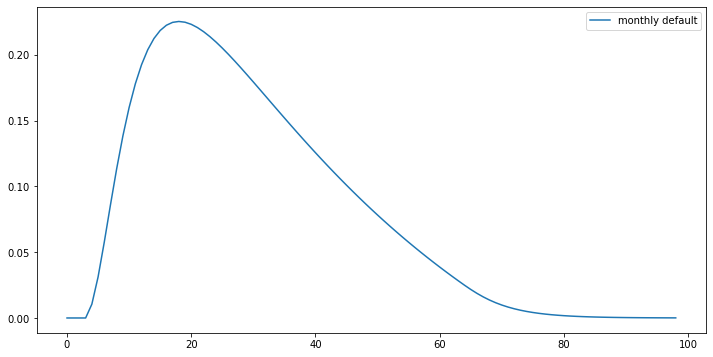

In [9]:
monthly_default = []
for k in range(1,len(p100)):
    m = p100[:,5][k] - p100[:,5][k-1]
    monthly_default.append(m)
defs = pd.DataFrame({'monthly default' : monthly_default})
defs.plot(figsize=(12,6))